In [1]:
import pylab
import imageio
import numpy as np
from skimage.util import pad, crop
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
filename = 'data/derrick.mp4'
vid = imageio.get_reader(filename, 'ffmpeg')

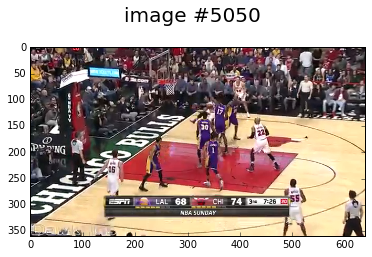

In [123]:
#works on 1125, 1150, 1200, 1350
nums = [5050,]
for num in nums:
    image = vid.get_data(num)
    fig = pylab.figure()
    fig.suptitle('image #{}'.format(num), fontsize=20)
    pylab.imshow(image)

In [124]:
image.shape

(360, 640, 3)

In [125]:
original = np.copy(image)

# COURT MASKING

In [126]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from collections import deque

In [127]:
def get_dominant_colorset(_bgr_img, thresh=0.02):
    img = cv2.cvtColor(_bgr_img, cv2.COLOR_BGR2YCR_CB)[40:340]
    hist = cv2.calcHist([img], [1,2], None, [256,256], [0,256,0,256])
    
    peak1_flat_idx = np.argmax(hist)
    peak1_idx = np.unravel_index(peak1_flat_idx, hist.shape)
    peak1_val = hist[peak1_idx]
    connected_hist1, sum1, subtracted_hist = get_connected_hist(hist,peak1_idx,thresh)
    
    return connected_hist1

### YCR_CB Ignoring Y

In [128]:
test = cv2.cvtColor(original, cv2.COLOR_BGR2YCR_CB)

for row in xrange(test.shape[0]):
    for col in xrange(test.shape[1]):
        idx = (row, col)
        _, cr, cb = test[idx]
        test[idx]=[50,cr,cb]

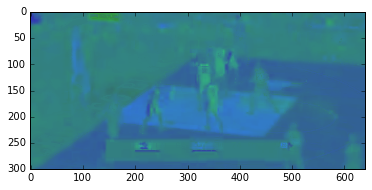

In [129]:
pylab.imshow(test[40:340])

In [130]:
def get_connected_hist(hist, peak_idx, thresh):
    connected_hist = set()
    sum_val = 0
    subtracted_hist = np.copy(hist)
    
    min_passing_val = thresh * hist[peak_idx]
    
    connected_hist.add(peak_idx)
    sum_val += hist[peak_idx]
    subtracted_hist[peak_idx] = 0
    queue = deque([peak_idx])
    
    while queue:
        x, y = queue.popleft()
        toAdd = []
        if x > 1:
            toAdd.append((x-1,y))
        if x < hist.shape[0] - 1:
            toAdd.append((x+1,y))
        if y > 1:
            toAdd.append((x, y-1))
        if y < hist.shape[1] - 1:
            toAdd.append((x, y+1))
        
        for idx in toAdd:
            if idx not in connected_hist and hist[idx] >= min_passing_val:
                connected_hist.add(idx)
                sum_val += hist[idx]
                subtracted_hist[idx] = 0
                queue.append(idx)
                
    return connected_hist, sum_val, subtracted_hist

In [131]:
def ycbcr_to_binary(ycbcr_img):
    img = ycbcr_img.copy()
    return ycbcr_to_gray(img) > 128

In [132]:
color_set = get_dominant_colorset(original,thresh=.02)

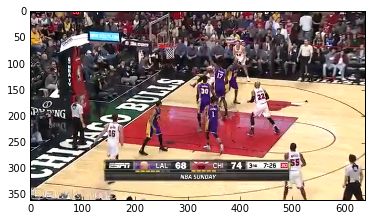

In [133]:
pylab.imshow(original)

In [134]:
def create_court_mask(_bgr_img, dominant_colorset, binary_gray=False):
    img = cv2.cvtColor(_bgr_img, cv2.COLOR_BGR2YCR_CB)
    #img = cv2.cvtColor(_bgr_img, cv2.COLOR_BGR2HSV)
    for row in xrange(img.shape[0]):
        for col in xrange(img.shape[1]):
            idx = (row, col)
            h, cr, cb = img[idx]
            #print img[idx]
            if (cr,cb) not in dominant_colorset:
                img[idx] = (0,128,128) #BLACK
            elif binary_gray:
                img[idx] = (255,128,128) #WHITE

    return ycbcr_to_gray(img) if binary_gray else img

def ycbcr_to_bgr(ycbcr_img):
    img = ycbcr_img.copy()
    return cv2.cvtColor(img, cv2.COLOR_YCR_CB2BGR)


def ycbcr_to_gray(ycbcr_img):
    img = ycbcr_img.copy()
    img = ycbcr_to_bgr(img)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [135]:
newest_img = create_court_mask(original,color_set,binary_gray=True)

In [136]:
newest_img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ..., 
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

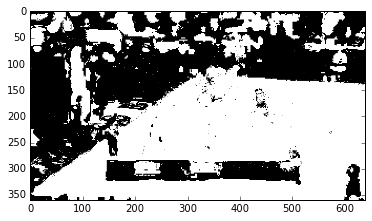

In [137]:
pylab.imshow(newest_img,"Greys")

In [138]:
def fill_holes_with_contour_filling(gray_mask,inverse=False):
    filled = gray_mask.copy()
    filled = pad(filled,((5,5),(0,0)),'constant',constant_values=255)
    if inverse:
        filled = cv2.bitwise_not(filled)
    image, contour, _ = cv2.findContours(filled, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contour:
        #print cv2.contourArea(cnt)
        #if cv2.contourArea(cnt)<50000:
            cv2.drawContours(filled,[cnt], 0, 255, -1)
    if inverse:
        filled = cv2.bitwise_not(filled)
    filled = crop(filled,((5,5),(0,0)))
    return filled

In [139]:
def get_double_flooded_mask(gray_mask):
    gray_flooded = fill_holes_with_contour_filling(gray_mask)
    gray_flooded2 = fill_holes_with_contour_filling(gray_flooded, inverse=True)
    return gray_flooded2

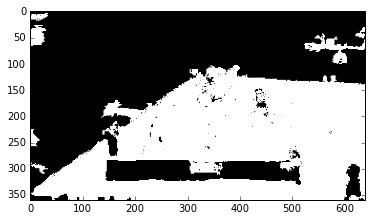

In [140]:
pylab.imshow(fill_holes_with_contour_filling(newest_img),"Greys")

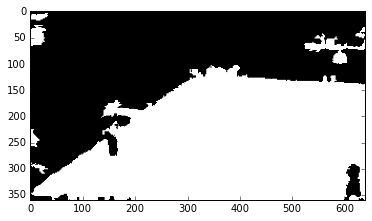

In [141]:
pylab.imshow(get_double_flooded_mask(newest_img),"Greys")

In [142]:
test = get_double_flooded_mask(newest_img)

In [143]:
kernel = np.ones((5,5),np.uint8)

In [165]:
def dilate_erode(image):
    kernel = np.ones((5,5),np.uint8)
    dilated = cv2.dilate(image,kernel,iterations=10)
    dilated = cv2.erode(dilated,kernel,iterations=10)
    dilated = cv2.erode(dilated,kernel,iterations=10)
    dilated = cv2.dilate(dilated,kernel,iterations=10)
    
    return dilated

In [166]:
dilated = dilate_erode(test)

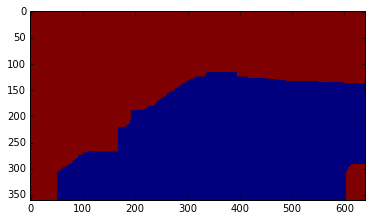

In [167]:
plt.imshow(dilated)

In [168]:
flooded_img = get_double_flooded_mask(newest_img)

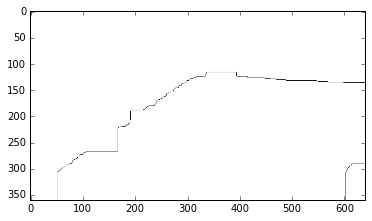

In [169]:
pylab.imshow(cv2.Canny(dilated,50,200),'Greys')

In [170]:
def get_lines(gray, thresh=55):
    flooded = fill_holes_with_contour_filling(gray, inverse=True)
    canny = cv2.Canny(flooded.copy(), 50, 200)
    lines = cv2.HoughLines(canny[0:0.79*canny.shape[0]], 1, np.pi/180, thresh)
    normal_lines = []
    for rho,theta in lines.reshape(lines.shape[0],2):
        if rho < 0:
            rho = -rho
            theta = theta - np.pi
        normal_lines.append([rho,theta])
    return normal_lines

def put_lines_on_img(bgr_img, lines_rho_theta,y_shift = 0, x_shift = 0):
    lined = bgr_img.copy()
    redness = np.linspace(0, 255, len(lines_rho_theta))
    redness = np.floor(redness)
    blueness = 255 - redness
    for i, (rho, theta) in enumerate(lines_rho_theta):
        # print 'The parameters of the line: rho = %s, theta = %s' %(rho, theta)
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b)+x_shift)
        y1 = int(y0 + 1000*(a)+y_shift)
        x2 = int(x0 - 1000*(-b)+x_shift)
        y2 = int(y0 - 1000*(a)+y_shift)
        red = redness[i]
        blue = blueness[i]
        cv2.line(lined,(x1,y1),(x2,y2),(100,0,200),2)
    return lined

def group_lines(lines_rho_theta):
    
    line_groups = []
    rho, theta = lines_rho_theta[0]
    line_groups.append([[rho,theta]])
    
    for rho, theta in lines_rho_theta[1:]:
        new_group = True
        if rho < 0:
            rho = -rho
            theta = theta - np.pi
        for key in range(len(line_groups)):
            # Append to list if close to existing theta
            if abs(line_groups[key][0][1] - theta) < 0.2 and abs(line_groups[key][0][0] - rho) < 50:
                line_groups[key].append([rho, theta])
                new_group = False
                break
        if new_group:
            line_groups.append([[rho, theta]])

    return line_groups

def average_line_group(line_groups):
    averages = []
    votes_appended = []
    votes = map(len,line_groups)
    
    for key in range(len(line_groups)):
        average = np.average(line_groups[key],axis=0)
        rho, theta = average

        if abs(average[1]) < .1 or abs(average[1]-np.pi/2) < .0001:
            pass
        else:            
            for idx, stored_avg in enumerate(averages):
                thetas = stored_avg[1]

                if abs(theta-thetas) < .3 and votes_appended[idx] > votes[key]:
                    #don't replace
                    #print 'DON"T REPLACE'
                    break
                elif abs(theta-thetas) < .3:
                    #replace existing value
                    #print 'REPLACE'
                    averages[idx] = average
                    votes_appended[idx] = votes[key]
                    break
                elif idx == len(averages)-1:
                    #print 'APPEND'
                    #append value to list
                    averages.append(average)
                    votes_appended.append(votes[key])
                    break
            if not averages:
                #print 'INITIALIZE'
                averages.append(average)
                votes_appended.append(votes[key])
    
    return averages

In [204]:
lines = get_lines(flooded_img,thresh=40)

/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [205]:
group_lines(lines)

[[[638.0, 0.0], [634.0, -0.017453344660349757], [641.0, 0.017453292]],
 [[105.0, 1.6231562],
  [96.0, 1.6406095],
  [133.0, 1.5707964],
  [114.0, 1.6057029],
  [89.0, 1.6580628],
  [124.0, 1.5882496],
  [142.0, 1.5533431],
  [80.0, 1.6755161],
  [62.0, 1.6929693],
  [73.0, 1.5707964],
  [83.0, 1.6580628],
  [105.0, 1.5184364],
  [75.0, 1.5707964]],
 [[0.0, 0.0]],
 [[280.0, 0.95993108],
  [275.0, 0.99483764],
  [273.0, 1.012291],
  [277.0, 0.97738439],
  [269.0, 1.0297443],
  [282.0, 0.94247776],
  [267.0, 1.0646509]]]

In [206]:
len(group_lines(lines))

4

In [207]:
average_lines = average_line_group(group_lines(lines))

In [208]:
average_lines

[array([ 98.53845978,   1.60973048], dtype=float32),
 array([ 274.71429443,    0.99733102], dtype=float32)]

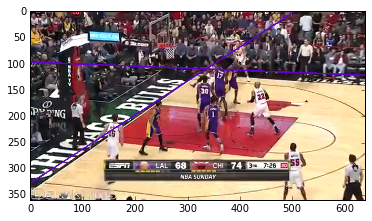

In [245]:
pylab.imshow(put_lines_on_img(original, average_lines))

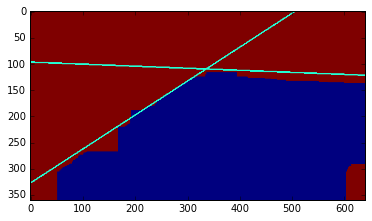

In [210]:
pylab.imshow(put_lines_on_img(dilated, average_lines))

# TESTING NEW COURT DETECTION

### HSV Ignoring H

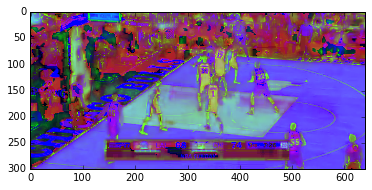

In [211]:
plt.imshow(cv2.cvtColor(original,cv2.COLOR_BGR2HSV)[40:340])

In [212]:
def get_dominant_colorset(_bgr_img, thresh=0.02):
    img = cv2.cvtColor(_bgr_img, cv2.COLOR_BGR2HSV)[40:340]
    hist = cv2.calcHist([img], [0], None, [256], [0,256])
    
    peak1_flat_idx = np.argmax(hist)
    peak1_idx = np.unravel_index(peak1_flat_idx, hist.shape)
    peak1_val = hist[peak1_idx]
    connected_hist1, sum1, subtracted_hist = get_connected_hist(hist,peak1_idx,thresh)
    
    return connected_hist1

In [213]:
def get_connected_hist(hist, peak_idx, thresh):
    connected_hist = set()
    sum_val = 0
    subtracted_hist = np.copy(hist)
    
    min_passing_val = thresh * hist[peak_idx]
    
    connected_hist.add(peak_idx)
    sum_val += hist[peak_idx]
    subtracted_hist[peak_idx] = 0
    queue = deque([peak_idx])
    
    while queue:
        x, y = queue.popleft()
        toAdd = []
        if x > 1:
            toAdd.append((x-1,y))
        if x < hist.shape[0] - 1:
            toAdd.append((x+1,y))
        if y > 1:
            toAdd.append((x, y-1))
        if y < hist.shape[1] - 1:
            toAdd.append((x, y+1))
        
        for idx in toAdd:
            if idx not in connected_hist and hist[idx] >= min_passing_val:
                connected_hist.add(idx)
                sum_val += hist[idx]
                subtracted_hist[idx] = 0
                queue.append(idx)
                
    return connected_hist, sum_val, subtracted_hist

In [214]:
def create_court_mask(_bgr_img, dominant_colorset, binary_gray=False):
    #img = cv2.cvtColor(_bgr_img, cv2.COLOR_BGR2YCR_CB)
    img = cv2.cvtColor(_bgr_img, cv2.COLOR_BGR2HSV)[40:340]
    for row in xrange(img.shape[0]):
        for col in xrange(img.shape[1]):
            idx = (row, col)
            h, cr, cb = img[idx]
            #print img[idx]
            if (h,0) not in dominant_colorset:
                img[idx] = (0,128,128) #BLACK
            elif binary_gray:
                img[idx] = (255,128,128) #WHITE

    return ycbcr_to_gray(img) if binary_gray else img

def ycbcr_to_bgr(ycbcr_img):
    img = ycbcr_img.copy()
    return cv2.cvtColor(img, cv2.COLOR_YCR_CB2BGR)


def ycbcr_to_gray(ycbcr_img):
    img = ycbcr_img.copy()
    img = ycbcr_to_bgr(img)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [215]:
def get_freethrow_line(gray, baseline, thresh=30):
    lines = get_lines(gray,thresh)
    possible_lines = []
    #return lines.reshape(lines.shape[0],2)
    for rho,theta in lines:
        if abs(theta - baseline[1]) < .2 and abs(rho - baseline[0]) > 50:
            possible_lines.append([rho,theta])
    
    average_ft = average_line_group(group_lines(np.array(possible_lines)))
    
    if len(average_ft) > 1:
        ft_line = []
        for rho, theta in average_ft:
            if abs(baseline[1])-abs(theta) > 0:
                ft_line.append([rho,theta])
        return ft_line
    return average_ft

def get_paint_line(gray, sideline, thresh=55):
    # Using padding requires 'thresh = 85' to work
    #     gray = gray[60:250]
    #     gray = pad(gray,((60,110),(0,0)),'constant')

    lines = get_lines(gray,thresh)
    possible_lines = []

    for rho,theta in lines:
        if abs(theta - sideline[1]) < .25 and rho - sideline[0] > 40:
            possible_lines.append([rho,theta]) 
    return average_line_group(group_lines(np.array(possible_lines)))
    #return group_lines(np.array(possible_lines))

In [216]:
#.107 works     .13 for right side of court

In [217]:
hsv_color_set = get_dominant_colorset(original,thresh=.107)

In [218]:
hsv_binary = create_court_mask(original, hsv_color_set,binary_gray=True)

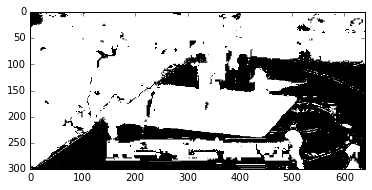

In [219]:
plt.imshow(hsv_binary,'Greys')

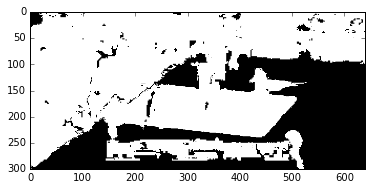

In [220]:
pylab.imshow(fill_holes_with_contour_filling(hsv_binary),"Greys")

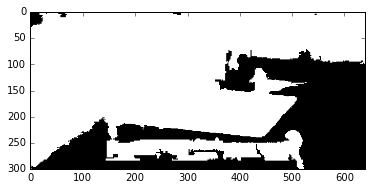

In [221]:
pylab.imshow(get_double_flooded_mask(hsv_binary),"Greys")

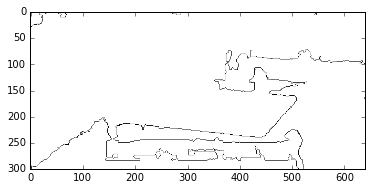

In [222]:
pylab.imshow(cv2.Canny(get_double_flooded_mask(hsv_binary),50,200),'Greys')

In [234]:
#get_+lines(hsv_binary[75:200,50:400])
flooded_hsv = get_double_flooded_mask(hsv_binary)

In [235]:
sideline = average_lines[0]
baseline = average_lines[1]

In [236]:
baseline

array([ 274.71429443,    0.99733102], dtype=float32)

In [237]:
def dilate_erode(image):
    kernel = np.ones((5,5),np.uint8)
    dilated = cv2.dilate(image,kernel,iterations=10)
    dilated = cv2.erode(dilated,kernel,iterations=10)
    dilated = cv2.erode(dilated,kernel,iterations=10)
    dilated = cv2.dilate(dilated,kernel,iterations=10)
    
    return dilated

In [238]:
plt.imshow()

TypeError: imshow() takes at least 1 argument (0 given)

In [240]:
hsv_ft_line = get_freethrow_line(dilate_erode(flooded_hsv),baseline,thresh=20)
hsv_paint_line = get_paint_line(dilate_erode(flooded_hsv),sideline,thresh=85)

/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [241]:
hsv_ft_line

[array([ 479.        ,    0.80285144], dtype=float32)]

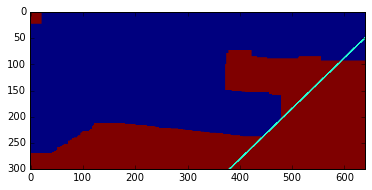

In [242]:
plt.imshow(put_lines_on_img(dilate_erode(flooded_hsv),hsv_ft_line))

In [243]:
original_with_lines = put_lines_on_img(original, average_lines)

#y_shift=40 due to cropping the image to [40:340]
original_with_lines = put_lines_on_img(original_with_lines, hsv_paint_line,y_shift=40)
original_with_lines = put_lines_on_img(original_with_lines, hsv_ft_line,y_shift=40)

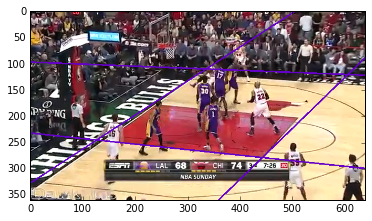

In [244]:
plt.imshow(original_with_lines)

# Homography: Transforming Perspective

In [53]:
print baseline
print sideline
print hsv_paint_line[0]
print hsv_ft_line[0]

[ 174.            0.95993108]
[ 93.89473724   1.60386562]
[ 158.           1.6406095]
[ 298.44445801    0.90854084]


In [54]:
def get_intersection(line_1, line_2, y_offset1 = 0, y_offset2 = 0):
    rho_1, theta_1 = line_1
    rho_2, theta_2 = line_2
    a_1 = np.cos(theta_1)
    b_1 = np.sin(theta_1)
    slope_1 = a_1 / -b_1
    intercept_1 = rho_1 / b_1 + y_offset1
    
    a_2 = np.cos(theta_2)
    b_2 = np.sin(theta_2)
    slope_2 = a_2 / -b_2
    intercept_2 = rho_2 / b_2 + y_offset2

    x_intersection = (intercept_2 - intercept_1) / (slope_1 - slope_2)
    y_intersection = x_intersection * slope_1 + intercept_1

    return (x_intersection, y_intersection)

In [55]:
get_intersection(baseline,sideline)

(161.5579838514727, 99.290662604055242)

In [56]:
def get_points(base, side, paint, ft):
    points = [get_intersection(base,side),
              get_intersection(side, ft, y_offset2=40),
              get_intersection(paint,ft,y_offset1 = 40, y_offset2 = 40),
              get_intersection(base,paint, y_offset2 = 40)]
    return np.array(points)

In [57]:
get_points(baseline,sideline,hsv_paint_line[0],hsv_ft_line[0])

array([[ 161.55798385,   99.2906626 ],
       [ 399.2325038 ,  107.15325872],
       [ 258.99909483,  216.49679982],
       [  18.2162522 ,  199.65962268]])

In [58]:
from skimage import transform as tf

(-0.5, 1699.5, 1699.5, -0.5)

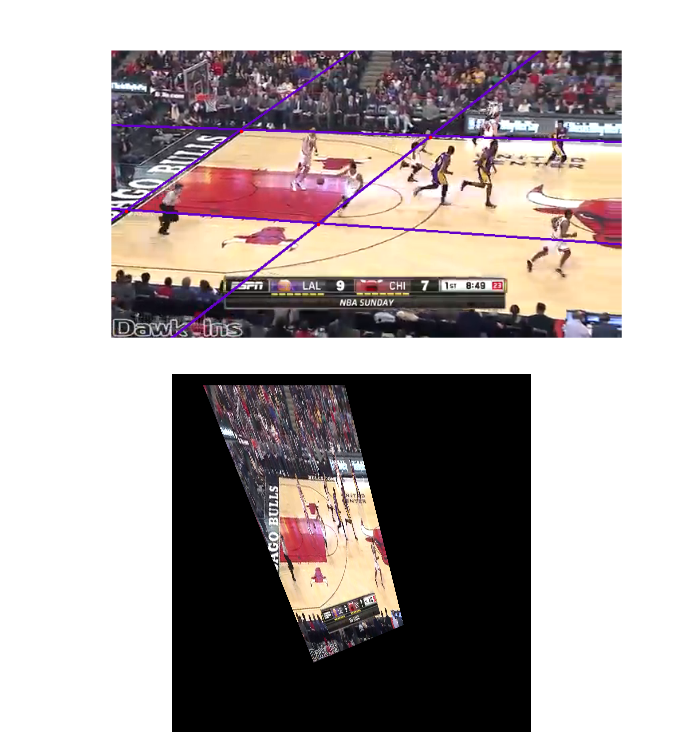

In [59]:
%matplotlib inline
margins = dict(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)

text = original_with_lines

CONSTANT = 500
src = np.array((
    (0+CONSTANT, 0+CONSTANT),
    (228+CONSTANT, 0+CONSTANT),
    (228+CONSTANT, 396+CONSTANT),
    (0+CONSTANT, 396+CONSTANT)
))


dst = get_points(baseline,sideline,hsv_paint_line[0],hsv_ft_line[0])

tform3 = tf.ProjectiveTransform()
tform3.estimate(src, dst)
warped = tf.warp(original, tform3,output_shape=(1700,1700))
tform3.params


fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))
fig.subplots_adjust(**margins)
plt.gray()
ax1.imshow(text)
ax1.plot(dst[:, 0], dst[:, 1], '.r')
ax1.axis('off')
ax2.imshow(warped)
ax2.axis('off')

In [60]:
tform3.params

array([[  9.76846520e-01,  -3.89715008e-01,  -1.20849204e+02],
       [ -6.06029596e-05,   2.40931787e-01,  -1.42870721e+01],
       [ -3.44623264e-04,  -1.50411364e-04,   1.31658582e+00]])

### Mean-Shift

In [23]:
import cv2
import numpy as np
import os
%matplotlib inline

In [24]:
cap =cv2.VideoCapture('data/derrick.mp4')

In [25]:
cap.get(4)

360.0

In [26]:
#current framerate
fps = cap.get(5)

In [27]:
frameCount = 0
fourcc = cv2.VideoWriter_fourcc(*'FMP4')
out = cv2.VideoWriter('data/test2.mp4',fourcc,fps,(640,360))

while (True):
    frameCount+=1
    ret, frame = cap.read()
    if ret==True:
        if frameCount >4800 and frameCount < 5150:
            out.write(frame)
        
#         cv2.imshow('frame',frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    else:
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()

In [17]:
cap = cv2.VideoCapture('test.mp4')

# take first frame of the video
ret,frame = cap.read()

# setup initial location of window
r,h,c,w = 175,45,263,5  # simply hardcoded the values
track_window = (c,r,w,h)

# set up the ROI for tracking
roi = frame[r:r+h, c:c+w]
hsv_roi =  cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 2 )

while(1):
    ret ,frame = cap.read()

    if ret == True:
        #hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # apply meanshift to get the new location
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # Draw it on image
        x,y,w,h = track_window
        img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        cv2.imshow('img2',img2)

        k = cv2.waitKey(40) & 0xff
        if k == 27:
            break
        else:
            cv2.imwrite(chr(k)+".jpg",img2)

    else:
        break

cv2.destroyAllWindows()
cap.release()

In [12]:
cap.release

In [3]:
ret, frame = cap.read()
cv2.imshow('frame',frame)
cv2.waitKey(60)
cap.release()
cv2.destroyAllWindows()

In [19]:
import numpy as np

In [38]:
from skimage.color import rgb2grey

In [40]:
new_image = rgb2grey(image)

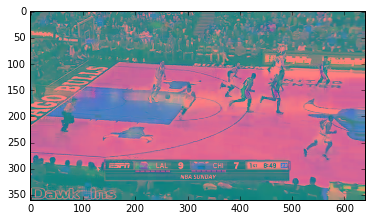

In [116]:
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2YCR_CB))

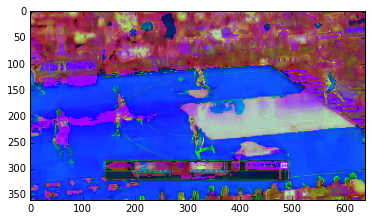

In [58]:
pylab.imshow(hsv)

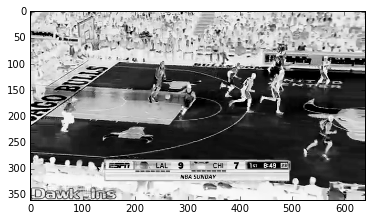

In [54]:
pylab.imshow(new_image,'Greys')

### Adding Padding

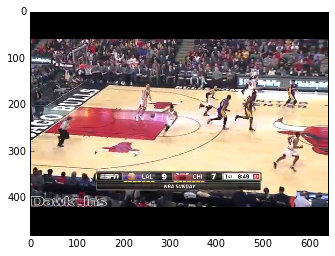

In [55]:
pylab.imshow(pad(image,((60,60),(0,0),(0,0)),'constant'))

In [2]:
imageio.imwrite('06966500_640x480.png',pad(image,((60,60),(0,0),(0,0)),'constant'))

NameError: name 'pad' is not defined

# Getting Coordinates for players

In [53]:
filename = 'data/derrick.mp4'
vid = imageio.get_reader(filename, 'ffmpeg')

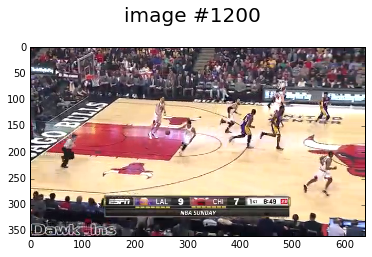

In [54]:
#works on 1125, 1150, 1200, 1350
nums = [1200,]
for num in nums:
    image = vid.get_data(num)
    fig = pylab.figure()
    fig.suptitle('image #{}'.format(num), fontsize=20)
    pylab.imshow(image)

In [44]:
import cv2
import matplotlib.pyplot as plt
import imageio

%matplotlib qt
class TestClass():
    def __init__(self,fname,txt):
        self.fname = fname
        self.img = imageio.imread(fname)
        self.point = ()
        self.pair = ()
        self.clicks = 0
        self.boxes = '"{}":'.format(fname)
        self.txt = txt
        
        fig = plt.figure()
        plt.imshow(self.img)
        cid = fig.canvas.mpl_connect('button_press_event', self.__onclick__)
        clid = fig.canvas.mpl_connect('close_event', self.__handle_close__)
        plt.show()

    def __onclick__(self, click):
        self.clicks += 1
        if self.clicks % 2 == 0:
            x, y = self.point
            self.point = (x, y, float(int(click.xdata)), float(int(click.ydata)))
            self.boxes += ' {},'.format(self.point)
        else:
            self.point = (float(int(click.xdata)), float(int(click.ydata)))
        print self.point
        return self.point
    
    def __handle_close__(self, evt):
        self.boxes = self.boxes.strip(',')
        self.boxes += ';\n'
        with open(self.txt, 'a') as text_file:
            text_file.write(self.boxes)
        print '{}'.format(self.boxes)

In [47]:
%matplotlib qt
# for i in range(10):
a = TestClass('06966500_640x480.png','test.idl')


(227.0, 145.0)
(227.0, 145.0, 258.0, 218.0)
(291.0, 190.0)
(291.0, 190.0, 323.0, 257.0)
"06966500_640x480.png": (227.0, 145.0, 258.0, 218.0), (291.0, 190.0, 323.0, 257.0);


In [31]:
a

<__main__.TestClass instance at 0x7f62b87c13b0>

In [11]:
test = '"06966500_640x480.png": (314.0, 265.0, 282.0, 187.0), (253.0, 233.0, 226.0, 141.0), (369.0, 154.0, 399.0, 221.0),'

In [14]:
test.strip(',')

'"06966500_640x480.png": (314.0, 265.0, 282.0, 187.0), (253.0, 233.0, 226.0, 141.0), (369.0, 154.0, 399.0, 221.0)'

In [51]:
a.boxes

'"06966500_640x480.png": (242.0, 146.0, 257.0, 227.0), (292.0, 195.0, 310.0, 271.0), (376.0, 153.0, 396.0, 224.0),'

In [ ]:
'''
"brainwash_11_13_2014_images/00001000_640x480.png": (63.0, 260.0, 89.0, 287.0), (115.0, 174.0, 135.0, 193.0), (155.0, 158.0, 168.0, 174.0), (184.0, 162.0, 203.0, 180.0), (182.0, 137.0, 196.0, 150.0), (283.0, 124.0, 301.0, 143.0), (292.0, 132.0, 305.0, 145.0), (321.0, 119.0, 338.0, 134.0), (295.0, 161.0, 311.0, 180.0), (320.0, 173.0, 344.0, 192.0), (328.0, 222.0, 362.0, 261.0), (470.0, 245.0, 513.0, 289.0);
'''

